In [1]:
import pandas as pd
import numpy as np
import random
import math
import scipy
from scipy import stats

from sklearn.preprocessing import StandardScaler  # for feature scaling
from sklearn.model_selection import train_test_split  # for train/test split
import matplotlib.pyplot as plt  #For representation
from sklearn.linear_model import LogisticRegression
from sklearn.svm import l1_min_c  # for L1 regluarization path

# Netork modules
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim

import copy

# Initialize

Define funtions

### Synthetic data

In [2]:
# Initialise sklearn LR (used for comparison)

logreg = LogisticRegression()

In [3]:
# Make synthetic data #
#=====================#


def make_synth_data(n_features = 3, n_sample = 1000, true_coefs = [1.,2.,3.]):
    # initialise
    df = pd.DataFrame()

    ## parameters
    #n_features = 3
    #n_sample = 100000

    ## True coefficients in linear function
    #true_coefs = [random.randrange(-5, 5) for i in range(n_features)]
    #true_coefs = [3, -2, 1]

    # Standardization of variables
    mean_vars = [0 for i in range(n_features)]
    var_vars = [1 for i in range(n_features)]

    # Amount of noise to add to  each variable
    noise_scale = [i**2 for i in range(n_features)]
    #noise_scale = [0.05*i/(n_features-1)**2 for i in noise_scale]
    noise_scale = [0 for i in noise_scale]

    # create normal variables
    for n in range(n_features):
        df[n] =  np.random.normal(loc=mean_vars[n], scale=var_vars[n], size=n_sample)

    # create linear combination
    df["x"] = 0
    for n in range(n_features):
        df["x"] +=  true_coefs[n]*df[n]

    # Generate outcome

    df["p"] = df.apply(lambda row: 1./(1. + math.exp(-row["x"])), axis=1)
    df["y"] = df.apply(lambda row: np.random.binomial(1, row["p"] ), axis=1)

    # Add noise to each variable
    df_noisy = df.copy()

    for n in range(n_features):
        df_noisy[n] += np.random.normal(loc=0.0, scale=noise_scale[n], size=n_sample)

    #df = df.drop(["x", "p"], axis=1)
    df_noisy = df_noisy.drop(["x", "p"], axis=1)

    # rename the indpendent variables
    ind_var_rename = dict()
    for ind_var_in in range(n_features) :
        ind_var_rename[ind_var_in] = "x"+f"{ind_var_in}"
    df = df.rename(columns=ind_var_rename)
    df_noisy = df_noisy.rename(columns=ind_var_rename)

    ind_var_names = list(ind_var_rename.values())


    # Split the data
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
    df_train, df_test, df_noisy_train, df_noisy_test = train_test_split(df, df_noisy, test_size=0.2, random_state=1234)

    # Standardize each split

    for indep_var in ind_var_names:
        df_train[indep_var] = stats.zscore(df_train[indep_var]) 
        df_test[indep_var] = stats.zscore(df_test[indep_var]) 

        df_noisy_train[indep_var] = stats.zscore(df_noisy_train[indep_var]) 
        df_noisy_test[indep_var] = stats.zscore(df_noisy_test[indep_var]) 

    # scale data
    #sc = StandardScaler()
    #df_train = sc.fit_transform(df_train)
    #X_test = sc.transform(X_test)

    return df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs


### Torch LR functions

In [4]:

#==================#
#    Load Data     #
#==================#


class SynthDataset(Dataset):


    def __init__(self, df):
        """Initializes instance of class SynthDataset.

        Args:
            df: Pandas dataframe.

        """

#sc = StandardScaler()
#df_train = sc.fit_transform(df_train)

        # The target is binary
        self.target = ["y"]   #["flow", "handling", "respect"]
        self.features = ind_var_names
        self.data_frame = df.loc[:, self.target+self.features]
        self.n_features = len(self.features)

        # Save target and predictors
        self.x = self.data_frame[self.features]
        self.y = self.data_frame.loc[:,"y"]


    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Convert idx from tensor to list due to pandas bug (that arises when using pytorch's random_split)
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()

#        return [self.X.iloc[idx].values, self.y[idx]]
#        return  {"X": self.X.iloc[idx].values, 'flow': self.flow.iloc[idx].values, 'handling': self.handling.iloc[idx].values, 'respect': self.respect.iloc[idx].values}
        return  [self.x.iloc[idx].values.astype(float),  self.y.iloc[idx].astype(float)] #,  self.handling.iloc[idx].astype(float),  self.respect.iloc[idx].astype(float)]

#test = SynthDataset(df_noisy)


In [5]:

# Create model
# f = wx + b, sigmoid at the end
class TorchLogisticRegression(nn.Module):

    def __init__(self, n_input_features):
        super(TorchLogisticRegression, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):
        y_predicted = torch.sigmoid(self.linear(x))
        return y_predicted
    
#model = TorchLogisticRegression(n_features)

#[p[1] for p in enumerate(model.parameters())]

In [6]:
#t = torch.from_numpy(np.array([[1,2,1]]))

#s = [p[1] for p in enumerate(model.parameters())][0].abs()

#(torch.mul(t,s), s)

#[p[1] for p in enumerate(model.parameters())][1]


In [7]:
#class CustomLoss(nn.Module):
#    def __init__(self, weight):
#        super(CustomLoss, self).__init__()
#        self.weight = weight
#
#    def forward(self, input, target):
#        # Compute the loss
#        loss = torch.mean(self.weight * (input - target) ** 2)
#        return loss
    

class mnbLoss(nn.Module):
    def __init__(self):
        super(mnbLoss, self).__init__()
        #self.weight = weight

    def forward(self, input, target):
        # Compute the loss
        #loss = torch.mean(self.weight * (input - target) ** 2)

        #loss = -torch.mean(target*input+(1-target)*(input*torch.log(1-input)))
        loss = -torch.sum(target*input+(1-target)*(input*torch.log(1-input)))
        return loss
    

test = mnbLoss()

input_tensor = torch.randn(3, requires_grad=True)
target_tensor = torch.randn(3)

test_loss = test(input_tensor,target_tensor )

test_loss.backward()

In [8]:
#=======================#
#     LR Training       #
#=======================#


def lr_train(train_in, n_epochs=100, learn_rate = 0.01, save_name_mod = "", loss_fun = 'log'):

    # Load dataset
    train_dataset_orig = SynthDataset(train_in)

    train_x = torch.from_numpy(train_dataset_orig.x.to_numpy().astype(np.float32) )
    train_y = torch.from_numpy(train_dataset_orig.y.to_numpy().astype(np.float32))

    train_y = train_y.view(train_y.shape[0], 1)

    # Define the model
    net=TorchLogisticRegression(train_dataset_orig.n_features)
    
    # Loss function

    if loss_fun == 'log':
        criterion = nn.BCELoss()
    elif loss_fun == 'mnb':
        criterion = mnbLoss()

    # Optimizer
    #optimizer = optim.Adam(net.parameters(), lr=learn_rate, weight_decay=w_decay)
    optimizer = torch.optim.SGD(net.parameters(), lr=learn_rate)
    #optimizer = optim.Adam(net.parameters(),  lr = 0.001, weight_decay = 0.0001 )
   
    #torch.optim.SGD(model.parameters(), lr=learning_rate)
    #optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    #optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)



    for epoch in range(n_epochs):

        y_pred = net(train_x )

        loss=criterion(y_pred, train_y )

        loss.backward()
        optimizer.step()
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        #if (epoch+1) % 10 == 0:
        #    print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')        

    return net

In [15]:
#===================================#
#     Regularized LR Training       #
#===================================#

#tps://www.geeksforgeeks.org/l1l2-regularization-in-pytorch/

def reg_lr_train(net, train_in, n_epochs=100, learn_rate = 0.01, save_name_mod = "", loss_fun = 'log', regularization_type = 'L1', weights = [], lambda_reg = 0.01):

    # Load dataset
    train_dataset_orig = SynthDataset(train_in)

    train_x = torch.from_numpy(train_dataset_orig.x.to_numpy().astype(np.float32) )
    train_y = torch.from_numpy(train_dataset_orig.y.to_numpy().astype(np.float32))

    train_y = train_y.view(train_y.shape[0], 1)

    # Define the model
    #net=TorchLogisticRegression(train_dataset_orig.n_features)
    
    # Loss function

    if loss_fun == 'log':
        criterion = nn.BCELoss()
    elif loss_fun == 'mnb':
        criterion = mnbLoss()

    # Optimizer
    #optimizer = optim.Adam(net.parameters(),  learn_rate = 0.001, w_decay = 0.0001 )
    
    #optimizer = torch.optim.SGD(net.parameters(), lr=learn_rate)
    optimizer = torch.optim.SGD(net.parameters(), lr=learn_rate)
    #torch.optim.SGD(model.parameters(), lr=learning_rate)
    #optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    #optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)


    #t = torch.from_numpy(np.array([[1,2,1]]))
    #
    #s = [p[1] for p in enumerate(model.parameters())][0].abs()

    # A tensor of weights for the weighted L1
    if regularization_type == 'weighted_L1':
        weights = [
            torch.from_numpy(np.array([weights])),
            torch.from_numpy(np.array([1.0])),
        ]

    

    for epoch in range(n_epochs):

        y_pred = net(train_x )

        loss=criterion(y_pred, train_y )

        # add regularization term #
        #-------------------------#

        # Apply L1 regularization
        if regularization_type == 'L1':
            #l1_norm = sum(p.abs().sum() for p in net.parameters() )
            #l1_norm = [p.abs().sum() for p in net.parameters()][0] 
            l1_norm = [p.abs().sum() for p in net.parameters()][0] 
            #l1_norm = torch.mean(p.abs().sum() for p in net.parameters() )

            loss += lambda_reg * l1_norm
            
        # Apply weighted L1 regularization
        elif regularization_type == 'weighted_L1':
            wl1_norm = sum(torch.mul(weights[p[0]], p[1]).abs().sum() for p in enumerate(net.parameters()))
            loss += lambda_reg * wl1_norm



        loss.backward()
        optimizer.step()
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        #if (epoch+1) % 10 == 0:
        #    print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')   
    print("loss : ")     
    print(loss)
    return net

In [11]:
model = TorchLogisticRegression(3)



#[i for i in model.parameters()]

#0.1296 + 0.2704 + 0.3126 #+ 0.3820

#x = [p for p in model.parameters()]

#sum(p.abs().sum() for p in model.parameters())


[p.abs().sum() for p in model.parameters()][0]



#(sum(p.abs().sum() for p in x ) , x, 0.4243+ 0.0145+0.0897 + 0.3266, 0.4243+ 0.0145+0.0897, )

tensor(1.2012, grad_fn=<SumBackward0>)

## Minibatch version

In [12]:
def validate(loader, model, criterion, device):                       
    #correct = 0                                               
    #total = 0                                                 
    running_loss = 0.0                                        
    model.eval()
      
    with torch.no_grad():                                     
        for i, data in enumerate(loader):                     
            inputs, labels = data                             
            inputs = inputs.to(device)                        
            labels = labels.to(device)                        
            
            outputs = model(inputs.float()).squeeze()    

            labels_hat=outputs.float()

            #loss = criterion(labels_hat, labels1.squeeze().type(torch.LongTensor)-1)
            loss = criterion(labels_hat.double(), labels.double())

            running_loss = running_loss + loss.item()
         
    return running_loss/(i+1)

In [13]:
def lr_train_minibatch(train_in, n_epochs=100, batch_size = 30, learn_rate = 0.01, save_name_mod = "", loss_fun = 'log'):
    """Trains the model.
    Args:
        csv_file (str): Absolute path of the dataset used for training.
        n_epochs (int): Number of epochs to train.
    """
    # Load dataset
    train_dataset_orig = SynthDataset(train_in)

    train_size = int(0.8 * len(train_dataset_orig))
    valid_size = len(train_dataset_orig) - train_size
    train_dataset, valid_dataset = random_split(train_dataset_orig, [train_size, valid_size])

    # Dataloaders
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Define the model
    net=TorchLogisticRegression(train_dataset_orig.n_features)
    
    # Loss function

    if loss_fun == 'log':
        criterion = nn.BCELoss()
    elif loss_fun == 'mnb':
        criterion = mnbLoss()

    # Optimizer
  
    optimizer = torch.optim.SGD(net.parameters(), lr=learn_rate)

    # Train the net
    loss_per_iter = []
    loss_per_batch = []

    #valid_loss_per_iter = []
    valid_loss_per_batch = []

    best_loss = np.inf

    for epoch in range(n_epochs):

        running_loss = 0.0
        for i, (inputs, label) in enumerate(trainloader):
            inputs = inputs.to(device)
            label = label.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = net(inputs.float() ).squeeze()

            label_hat=outputs.float()

            #print("main: inputs = "+str(inputs.shape) + " outputs = "+ str(outputs.shape))
            #print("main: label_hat = "+str(label_hat.shape) + " label = "+ str(label.shape))

            # calculate loss
            #loss=criterion(label_hat, label.squeeze().type(torch.LongTensor)-1)
            loss=criterion(label_hat.double(), label.double() )

            

            #loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            # Save loss to plot
            running_loss += loss.item()
            loss_per_iter.append(loss.item())

        loss_per_batch.append(running_loss / (i + 1))
        running_loss = 0.0

        # Evaluate validation loss
        vloss = validate(validloader, net, criterion, device)
        valid_loss_per_batch.append(vloss)

        # If validation loss is lower than lowest then save the model
        #if vloss < best_loss:
        #    save_network(net, "best_model"+save_name_mod)
        #    best_loss = vloss

  
    #print("Root mean squared error")
    #print("Training:", np.sqrt(loss_per_batch[-1]))

    return{"model":net,
           "loss_per_batch": loss_per_batch,
           "valid_loss_per_batch": valid_loss_per_batch}



In [14]:
def reg_validate(loader, model, criterion, device, regularization_type = 'L1', weights = [], lambda_reg = 0.01):                       
    #correct = 0                                               
    #total = 0                                                 
    running_loss = 0.0                                        
    model.eval()
      
    with torch.no_grad():                                     
        for i, data in enumerate(loader):                     
            inputs, labels = data                             
            inputs = inputs.to(device)                        
            labels = labels.to(device)                        
            
            outputs = model(inputs.float()).squeeze()    

            labels_hat=outputs.float()

            #loss = criterion(labels_hat, labels1.squeeze().type(torch.LongTensor)-1)
            loss = criterion(labels_hat.double(), labels.double())


            # add regularization term #
            #-------------------------#

            # Apply L1 regularization
            if regularization_type == 'L1':
                #l1_norm = sum(p.abs().sum() for p in net.parameters() )
                #l1_norm = [p.abs().sum() for p in net.parameters()][0] 
                l1_norm = [p.abs().sum() for p in model.parameters()][0] 
                #l1_norm = torch.mean(p.abs().sum() for p in net.parameters() )

                loss += lambda_reg * l1_norm
            
            #  Apply weighted L1 regularization
            elif regularization_type == 'weighted_L1':
                wl1_norm = sum(torch.mul(weights[p[0]], p[1]).abs().sum() for p in enumerate(model.parameters()))
                loss += lambda_reg * wl1_norm
                

            running_loss = running_loss + loss.item()
         
    return running_loss/(i+1)

In [15]:
def reg_lr_train_minibatch(train_in, n_epochs=100, batch_size = 30, learn_rate = 0.01, save_name_mod = "", loss_fun = 'log', regularization_type = 'L1', weights = [], lambda_reg = 0.01):
    """Trains the model.
    Args:
        csv_file (str): Absolute path of the dataset used for training.
        n_epochs (int): Number of epochs to train.
    """
    # Load dataset
    train_dataset_orig = SynthDataset(train_in)

    train_size = int(0.8 * len(train_dataset_orig))
    valid_size = len(train_dataset_orig) - train_size
    train_dataset, valid_dataset = random_split(train_dataset_orig, [train_size, valid_size])

    # Dataloaders
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Define the model
    net=TorchLogisticRegression(train_dataset_orig.n_features)
    
    # Loss function

    if loss_fun == 'log':
        criterion = nn.BCELoss()
    elif loss_fun == 'mnb':
        criterion = mnbLoss()

    # Optimizer
  
    optimizer = torch.optim.SGD(net.parameters(), lr=learn_rate)

    # Train the net
    loss_per_iter = []
    loss_per_batch = []

    #valid_loss_per_iter = []
    valid_loss_per_batch = []

    best_loss = np.inf

    for epoch in range(n_epochs):

        running_loss = 0.0
        for i, (inputs, label) in enumerate(trainloader):
            inputs = inputs.to(device)
            label = label.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = net(inputs.float() ).squeeze()

            label_hat=outputs.float()

            #print("main: inputs = "+str(inputs.shape) + " outputs = "+ str(outputs.shape))
            #print("main: label_hat = "+str(label_hat.shape) + " label = "+ str(label.shape))

            # calculate loss
            #loss=criterion(label_hat, label.squeeze().type(torch.LongTensor)-1)
            loss=criterion(label_hat.double(), label.double() )

            # add regularization term #
            #-------------------------#

            # Apply L1 regularization
            if regularization_type == 'L1':
                #l1_norm = sum(p.abs().sum() for p in net.parameters() )
                #l1_norm = [p.abs().sum() for p in net.parameters()][0] 
                l1_norm = [p.abs().sum() for p in net.parameters()][0] 
                #l1_norm = torch.mean(p.abs().sum() for p in net.parameters() )

                loss += lambda_reg * l1_norm
            
            #  Apply weighted L1 regularization
            elif regularization_type == 'weighted_L1':
                wl1_norm = sum(torch.mul(weights[p[0]], p[1]).abs().sum() for p in enumerate(net.parameters()))
                loss += lambda_reg * wl1_norm

            #loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            # Save loss to plot
            running_loss += loss.item()
            loss_per_iter.append(loss.item())

        loss_per_batch.append(running_loss / (i + 1))
        running_loss = 0.0

        # Evaluate validation loss
        vloss = reg_validate(validloader, net, criterion, device, regularization_type = regularization_type, weights = weights, lambda_reg = lambda_reg)
        valid_loss_per_batch.append(vloss)

        # If validation loss is lower than lowest then save the model
        #if vloss < best_loss:
        #    save_network(net, "best_model"+save_name_mod)
        #    best_loss = vloss

  
    #print("Root mean squared error")
    #print("Training:", np.sqrt(loss_per_batch[-1]))

    return{"model":net,
           "loss_per_batch": loss_per_batch,
           "valid_loss_per_batch": valid_loss_per_batch}



In [16]:
#test_run_minibatch = lr_train_minibatch(df_train, n_epochs=100, batch_size = 10000, learn_rate=  1.0, save_name_mod = "", loss_fun = 'log')


#test_run_minibatch = reg_lr_train_minibatch(df_train, n_epochs=100, batch_size = 10000, learn_rate=  1.0, save_name_mod = "", loss_fun = 'log', lambda_reg = 0.01)

## Test Torch LR

### Agreement of LR parameters

In [9]:
# Create a dataset
#make_synth_data(n_features = 10, n_sample = 100000, true_coefs = [3, 2.5, -2.0, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])
#make_synth_data(n_features = 3, n_sample = 100000, true_coefs = [ 3,2,1 ])

df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
    make_synth_data(n_features = 10, n_sample = 100000, true_coefs = [3, 2.5, -2.0, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])

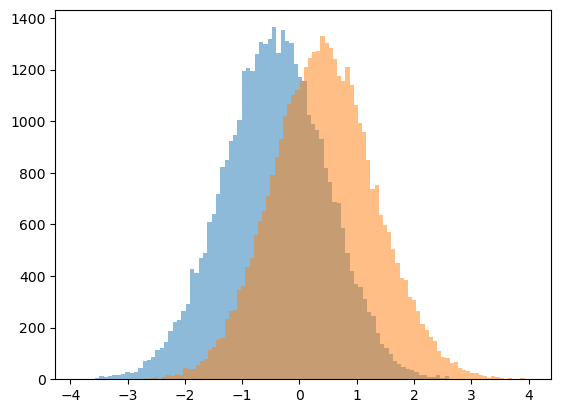

In [18]:
# Visualize synthetic data set

x1 = df_train.loc[df_train.y==0]['x0']
x2 = df_train.loc[df_train.y==1]['x0']

kwargs = dict(alpha=0.5, bins=100)

plt.hist(x1, **kwargs, label='0')
plt.hist(x2, **kwargs, label='1')
plt.show()


#plt.gca().set(title='Frequency Histogram of Diamond Depths', ylabel='Frequency')
#plt.xlim(50,75)
#plt.legend();

In [19]:
# Fit a logistic regression with sklearn

logreg.fit(df_train[ind_var_names], df_train["y"])

print(logreg.coef_)
#print(logreg.n_features_in_)

[[ 2.99215036  2.47970069 -1.98666351  1.80186623 -1.48302905  1.20525009
   0.78761691  0.49190875 -0.19542478  0.10812901]]


In [19]:
test_run = lr_train(df_train, n_epochs=1000, learn_rate=  1.0, save_name_mod = "", loss_fun = 'mnb')
#test_run = reg_lr_train(df_train, n_epochs=1000, learn_rate = 0.1, save_name_mod = "", loss_fun = 'mnb', regularization_type = 'weighted_L1', weights = [1.0, 1.0, 1.0])
test_run = reg_lr_train(test_run, df_train,  n_epochs=1000, learn_rate = 0.1, save_name_mod = "", loss_fun = 'mnb', regularization_type = 'L1', weights = [1.0, 1.0, 1.0])


print(df_train.shape)

loss : 
tensor(nan, grad_fn=<AddBackward0>)
(80000, 13)


In [20]:
test_run.linear.weight, test_run.linear.bias, true_coefs

(Parameter containing:
 tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
        requires_grad=True),
 Parameter containing:
 tensor([nan], requires_grad=True),
 [3, 2.5, -2.0, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2, 0.1])

In [22]:
#===================================#
#     Regularized LR Training       #
#===================================#

#tps://www.geeksforgeeks.org/l1l2-regularization-in-pytorch/

def reg_lr_train(net, train_in, n_epochs=100, learn_rate = 0.01, save_name_mod = "", loss_fun = 'log', regularization_type = 'L1', weights = [], lambda_reg = 0.01):

    # Load dataset
    train_dataset_orig = SynthDataset(train_in)

    train_x = torch.from_numpy(train_dataset_orig.x.to_numpy().astype(np.float32) )
    train_y = torch.from_numpy(train_dataset_orig.y.to_numpy().astype(np.float32))

    train_y = train_y.view(train_y.shape[0], 1)

    # Define the model
    #net=TorchLogisticRegression(train_dataset_orig.n_features)
    
    # Loss function

    if loss_fun == 'log':
        criterion = nn.BCELoss()
    elif loss_fun == 'mnb':
        criterion = mnbLoss()

    # Optimizer
    optimizer = optim.Adam(net.parameters(),  lr = 1.0)
    #optimizer = optim.ASGD(net.parameters(), lr=0.01)
    #optimizer = optim.LBFGS(net.parameters())
    #optimizer = optim.Rprop(net.parameters(), lr=1.0)

    #optimizer = torch.optim.SGD(net.parameters(), lr=learn_rate)
    #optimizer = torch.optim.SGD(net.parameters(), lr=learn_rate)
    

    #def closure():
    #    optim.lbfgs.zero_grad()
    #    objective = f(x_lbfgs)
    #    objective.backward()
    #    return objective

    #optimizer = torch.optim.LBFGS(net.parameters(), lr=1.0)
    #torch.optim.SGD(model.parameters(), lr=learning_rate)
    #optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    #optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)



    #t = torch.from_numpy(np.array([[1,2,1]]))
    #
    #s = [p[1] for p in enumerate(model.parameters())][0].abs()

    # A tensor of weights for the weighted L1
    if regularization_type == 'weighted_L1':
        weights = [
            torch.from_numpy(np.array([weights])),
            torch.from_numpy(np.array([1.0])),
        ]

    

    for epoch in range(n_epochs):

        y_pred = net(train_x )

        loss=criterion(y_pred, train_y )

        # add regularization term #
        #-------------------------#

        # Apply L1 regularization
        if regularization_type == 'L1':
            l1_norm = sum(p.abs().sum() for p in net.parameters() )
            #l1_norm = [p.abs().sum() for p in net.parameters()][0] 
            #l1_norm = [p.abs().sum() for p in net.parameters()][0] 
            #l1_norm = torch.mean(p.abs().sum() for p in net.parameters() )

            loss += lambda_reg * l1_norm
            
        # Apply weighted L1 regularization
        elif regularization_type == 'weighted_L1':
            wl1_norm = sum(torch.mul(weights[p[0]], p[1]).abs().sum() for p in enumerate(net.parameters()))
            loss += lambda_reg * wl1_norm



        loss.backward()
        optimizer.step()
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        #if (epoch+1) % 10 == 0:
        #    print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')   
    print("loss : ")     
    print(loss)
    return net

In [23]:
#===================================#
#     Regularized LR Training       #
#===================================#

#tps://www.geeksforgeeks.org/l1l2-regularization-in-pytorch/

def reg_lr_train(net, train_in, n_epochs=100, learn_rate = 0.01, save_name_mod = "", loss_fun = 'log', regularization_type = 'L1', weights = [], lambda_reg = 0.01):

    # Load dataset
    train_dataset_orig = SynthDataset(train_in)

    train_x = torch.from_numpy(train_dataset_orig.x.to_numpy().astype(np.float32) )
    train_y = torch.from_numpy(train_dataset_orig.y.to_numpy().astype(np.float32))

    train_y = train_y.view(train_y.shape[0], 1)

    # Define the model
    #net=TorchLogisticRegression(train_dataset_orig.n_features)
    
    # Loss function

    if loss_fun == 'log':
        criterion = nn.BCELoss()
    elif loss_fun == 'mnb':
        criterion = mnbLoss()

    # Optimizer
    #optimizer = optim.Adam(net.parameters(),  lr = 1.0)
    #optimizer = optim.ASGD(net.parameters(), lr=0.01)
    #optimizer = optim.LBFGS(net.parameters())
    #optimizer = optim.Rprop(net.parameters(), lr=1.0)

    #optimizer = torch.optim.SGD(net.parameters(), lr=learn_rate)
    #optimizer = torch.optim.SGD(net.parameters(), lr=learn_rate)
    

    #def closure():
    #    optim.lbfgs.zero_grad()
    #    objective = f(x_lbfgs)
    #    objective.backward()
    #    return objective
    def closure():
        
        lbfgs.zero_grad()
        y_pred = net(train_x )
        loss=criterion(y_pred, train_y)

        # add regularization term #
        #-------------------------#

        # Apply L1 regularization
        if regularization_type == 'L1':
            l1_norm = sum(p.abs().sum() for p in net.parameters() )
            #l1_norm = [p.abs().sum() for p in net.parameters()][0] 
            #l1_norm = [p.abs().sum() for p in net.parameters()][0] 
            #l1_norm = torch.mean(p.abs().sum() for p in net.parameters() )

            loss += lambda_reg * l1_norm
            
        # Apply weighted L1 regularization
        elif regularization_type == 'weighted_L1':
            wl1_norm = sum(torch.mul(weights[p[0]], p[1]).abs().sum() for p in enumerate(net.parameters()))
            loss += lambda_reg * wl1_norm

        loss.backward()
        return loss
        #optimizer.step()
        
        # Zero the parameter gradients
        #optimizer.zero_grad()
    

    lbfgs = optim.LBFGS(net.parameters())#,
                    #history_size=10, 
                    #max_iter=4, 
                    #line_search_fn="strong_wolfe")
    
    #optimizer = torch.optim.LBFGS(net.parameters(), lr=1.0)
    #torch.optim.SGD(model.parameters(), lr=learning_rate)
    #optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    #optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)



    #t = torch.from_numpy(np.array([[1,2,1]]))
    #
    #s = [p[1] for p in enumerate(model.parameters())][0].abs()

    # A tensor of weights for the weighted L1
    if regularization_type == 'weighted_L1':
        weights = [
            torch.from_numpy(np.array([weights])),
            torch.from_numpy(np.array([1.0])),
        ]

    

    for epoch in range(n_epochs):

        lbfgs.step(closure)

    #print("loss : ")     
    #print(loss)
    return net

In [24]:
n_sample = 10000

df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
    make_synth_data(n_features = 3, n_sample = n_sample, true_coefs = [3, 2.5, -2.0]) #, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])

test_run = lr_train(df_train, n_epochs=1000, learn_rate=  1.0, save_name_mod = "", loss_fun = 'log')

In [ ]:
test_run_minibatch = lr_train_minibatch(df_train, n_epochs=30, batch_size = 10000, learn_rate=  1.0, save_name_mod = "", loss_fun = 'log')

test_run_minibatch['model'].linear.weight, test_run_minibatch['model'].linear.bias, true_coefs

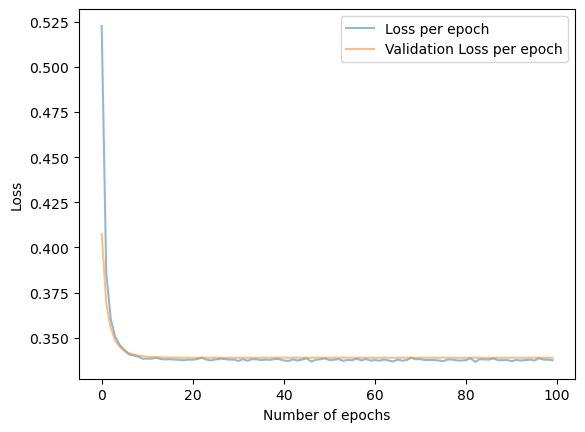

In [62]:
# plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
plt.plot(np.arange(len(test_run_minibatch['loss_per_batch'])), test_run_minibatch['loss_per_batch'], "-", alpha=0.5, label="Loss per epoch")
plt.plot(np.arange(len(test_run_minibatch['valid_loss_per_batch'])), test_run_minibatch['valid_loss_per_batch'], "-", alpha=0.5, label="Validation Loss per epoch")
#    #plt.plot(np.arange(len(loss_per_iter), step=4) + 3, loss_per_batch, ".-", label="Loss per mini-batch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [105]:
p1 = logreg.predict_proba(df_test[ind_var_names])

test_train_dataset_orig = SynthDataset(df_test)

test_x = torch.from_numpy(test_train_dataset_orig.x.to_numpy().astype(np.float32) )

p2 = test_run(test_x).detach().numpy()

p2

array([[0.5763351 ],
       [0.31676057],
       [0.9932608 ],
       ...,
       [0.99907196],
       [0.85202235],
       [0.42675185]], dtype=float32)

Text(0, 0.5, 'numerical optimization')

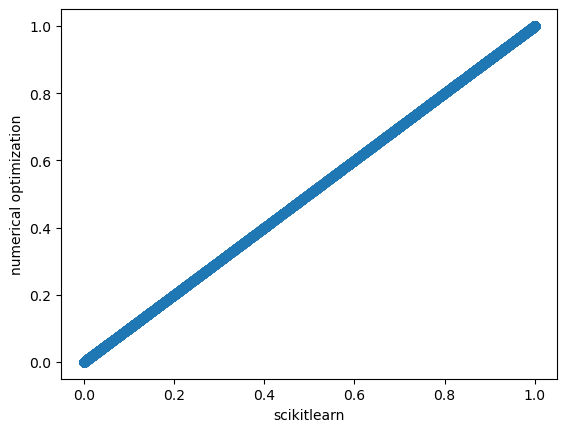

In [108]:
plt.scatter(p1[:, 1], p2)
plt.xlabel("scikitlearn")
plt.ylabel("numerical optimization")

Text(0, 0.5, 'model log ods')

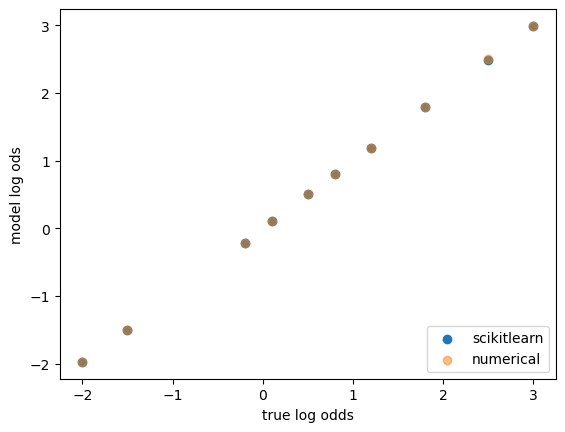

In [124]:
param1 = logreg.coef_[0]
param2 = test_run.linear.weight.detach().numpy()[0]

plt.scatter(true_coefs, param1, label = "scikitlearn")
plt.scatter(true_coefs, param2, label = "numerical", alpha=0.5)

plt.legend(loc='lower right')
plt.xlabel("true log odds")
plt.ylabel("model log ods")

### Test L1 regularization path

In [80]:
cs = l1_min_c(df_train[ind_var_names], df_train["y"], loss="log") * np.logspace(0, 10, 16)

clf = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    tol=1e-6,
    max_iter=int(1e6),
    warm_start=True,
    intercept_scaling=10000.0,
)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(df_train[ind_var_names], df_train["y"] )
    coefs_.append(clf.coef_.ravel().copy())

coefs_ = np.array(coefs_)

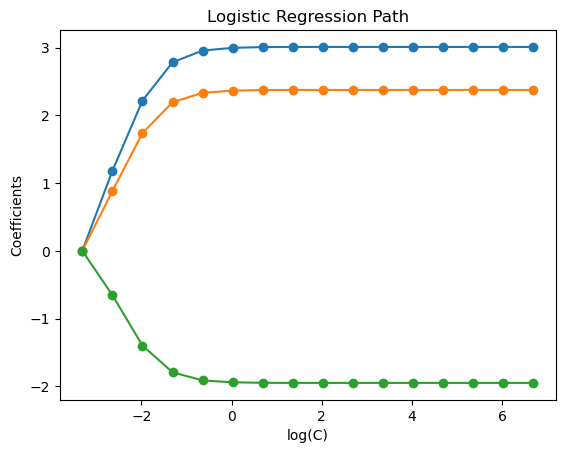

In [81]:
plt.plot(np.log10(cs), coefs_, marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Path")
plt.axis("tight")
plt.show()

In [15]:
coefs_.shape

np.logspace(10, 0, 16)
np.logspace(0, 10, 16)


array([1.00000000e+00, 4.64158883e+00, 2.15443469e+01, 1.00000000e+02,
       4.64158883e+02, 2.15443469e+03, 1.00000000e+04, 4.64158883e+04,
       2.15443469e+05, 1.00000000e+06, 4.64158883e+06, 2.15443469e+07,
       1.00000000e+08, 4.64158883e+08, 2.15443469e+09, 1.00000000e+10])

In [ ]:
cs = l1_min_c(df_train[ind_var_names], df_train["y"], loss="log") * np.logspace(10, 0, 16)

#cs = cs[0:8]
test_reg_path = {}

start_model = lr_train(df_train, n_epochs=10000, learn_rate=  1.0, save_name_mod = "", loss_fun = 'log')

for i, inv_lambda_reg in enumerate(cs):
    #fm = reg_lr_train(df_train, n_epochs=1000, learn_rate = 1.0, save_name_mod = "", loss_fun = 'log', regularization_type = 'L1', weights = [1.0, 1.0, 1.0])
    print("lambda")
    print(1./inv_lambda_reg)
    lda = 1./(inv_lambda_reg)
    lda = lda/n_sample
    #lda = lda/ n_features
    new_model = \
    reg_lr_train(start_model, df_train, n_epochs=1000, learn_rate = 1.0, save_name_mod = "", loss_fun = 'log', regularization_type = 'L1', weights = [1.0, 1.0, 1.0], lambda_reg=lda )

    test_reg_path[i] = copy.deepcopy(new_model)

    start_model = copy.deepcopy(new_model)


In [90]:
coefs_num = []

for i in test_reg_path.keys():
    coefs_num.append(test_reg_path[i].linear.weight.detach().numpy()[0])

coefs_num = np.vstack(coefs_num)

In [23]:
coefs_num

array([[ 2.9683466e+00,  2.5083408e+00, -1.9846694e+00,  1.7910748e+00,
        -1.5021963e+00,  1.2141036e+00,  7.8124583e-01,  4.9076813e-01,
        -1.7456611e-01,  9.7828016e-02],
       [ 2.9682260e+00,  2.5082376e+00, -1.9845858e+00,  1.7909988e+00,
        -1.5021307e+00,  1.2140493e+00,  7.8120756e-01,  4.9074158e-01,
        -1.7455085e-01,  9.7815491e-02],
       [ 2.9676652e+00,  2.5077579e+00, -1.9841969e+00,  1.7906457e+00,
        -1.5018262e+00,  1.2137969e+00,  7.8102976e-01,  4.9061811e-01,
        -1.7447999e-01,  9.7757362e-02],
       [ 2.9650667e+00,  2.5055354e+00, -1.9823947e+00,  1.7890096e+00,
        -1.5004147e+00,  1.2126271e+00,  7.8020573e-01,  4.9004585e-01,
        -1.7415154e-01,  9.7487837e-02],
       [ 2.9530871e+00,  2.4952886e+00, -1.9740856e+00,  1.7814662e+00,
        -1.4939070e+00,  1.2072327e+00,  7.7640563e-01,  4.8740596e-01,
        -1.7263559e-01,  9.6243404e-02],
       [ 2.8991959e+00,  2.4491878e+00, -1.9366964e+00,  1.7475171e+00,
   

In [240]:
coefs_num

array([[ 3.1015625 ,  2.5917969 , -2.046875  ,  1.8632812 , -1.5585938 ,
         1.2285156 ,  0.8339844 ,  0.51953125, -0.22265625,  0.10546875],
       [ 3.1015625 ,  2.5917969 , -2.046875  ,  1.8632812 , -1.5585938 ,
         1.2285156 ,  0.8339844 ,  0.51953125, -0.22265625,  0.10546875],
       [ 3.1015625 ,  2.5917969 , -2.046875  ,  1.8632812 , -1.5585938 ,
         1.2285156 ,  0.8339844 ,  0.51953125, -0.22265625,  0.10546875],
       [ 3.1015625 ,  2.5917969 , -2.046875  ,  1.8632812 , -1.5585938 ,
         1.2285156 ,  0.8339844 ,  0.51953125, -0.22265625,  0.10546875],
       [ 3.1015625 ,  2.5917969 , -2.046875  ,  1.8632812 , -1.5585938 ,
         1.2285156 ,  0.8339844 ,  0.51953125, -0.22265625,  0.10546875],
       [ 3.1015625 ,  2.5917969 , -2.046875  ,  1.8632812 , -1.5585938 ,
         1.2285156 ,  0.8339844 ,  0.51953125, -0.22265625,  0.10546875],
       [ 3.1015625 ,  2.5917969 , -2.046875  ,  1.8632812 , -1.5585938 ,
         1.2285156 ,  0.8339844 ,  0.51953125

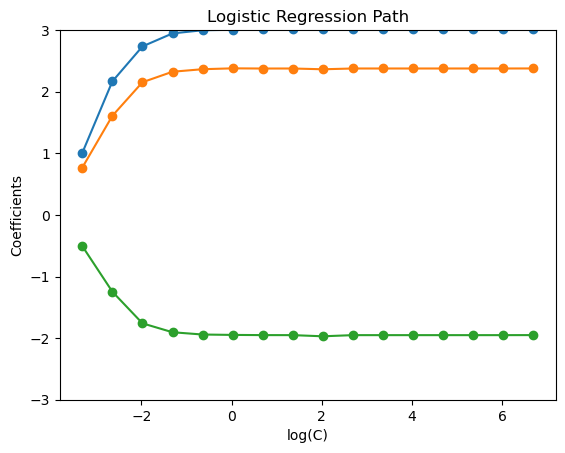

In [91]:
plt.plot(np.log10(cs[:]), coefs_num[:, :], marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Path")
plt.axis("tight")
plt.ylim(-3,3)
plt.show()

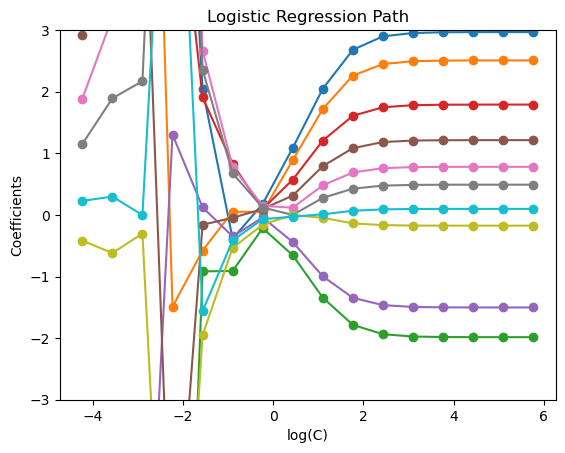

In [25]:
plt.plot(np.log10(cs[:]), coefs_num[:, :], marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Path")
plt.axis("tight")
plt.ylim(-3,3)
plt.show()


In [222]:
t = reg_lr_train(df_train, n_epochs=10000, learn_rate = 0.1, save_name_mod = "", loss_fun = 'log', regularization_type = 'L1', weights = [1.0, 1.0, 1.0], lambda_reg=10**4 )

t.linear.weight.detach().numpy()


epoch: 10, loss = 99980736.0000
epoch: 20, loss = 99979352.0000
epoch: 30, loss = 99977624.0000
epoch: 40, loss = 99975664.0000
epoch: 50, loss = 99973848.0000
epoch: 60, loss = 99972192.0000
epoch: 70, loss = 99970600.0000
epoch: 80, loss = 99968752.0000
epoch: 90, loss = 99967000.0000
epoch: 100, loss = 99965360.0000
epoch: 110, loss = 99963792.0000
epoch: 120, loss = 99962304.0000
epoch: 130, loss = 99960880.0000


epoch: 140, loss = 99959520.0000
epoch: 150, loss = 99958208.0000
epoch: 160, loss = 99956880.0000
epoch: 170, loss = 99955608.0000
epoch: 180, loss = 99954376.0000
epoch: 190, loss = 99953192.0000
epoch: 200, loss = 99952064.0000
epoch: 210, loss = 99950976.0000
epoch: 220, loss = 99949912.0000
epoch: 230, loss = 99948888.0000
epoch: 240, loss = 99947904.0000
epoch: 250, loss = 99946936.0000
epoch: 260, loss = 99946000.0000
epoch: 270, loss = 99945088.0000
epoch: 280, loss = 99944224.0000
epoch: 290, loss = 99943352.0000
epoch: 300, loss = 99942512.0000
epoch: 310, loss = 99941680.0000
epoch: 320, loss = 99940904.0000
epoch: 330, loss = 99940120.0000
epoch: 340, loss = 99939344.0000
epoch: 350, loss = 99938608.0000
epoch: 360, loss = 99937872.0000
epoch: 370, loss = 99937168.0000
epoch: 380, loss = 99936480.0000
epoch: 390, loss = 99935792.0000
epoch: 400, loss = 99935120.0000
epoch: 410, loss = 99934456.0000
epoch: 420, loss = 99933808.0000
epoch: 430, loss = 99933192.0000
epoch: 440

array([[ 2.9717312 ,  2.4823513 , -1.9530789 ,  1.7755276 , -1.4853665 ,
         1.1679226 ,  0.7927395 ,  0.4809353 , -0.1918728 ,  0.08347438]],
      dtype=float32)